In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cuda


In [3]:
import os
if not os.path.exists('Results'):
   os.makedirs('Results')
if not os.path.exists('Models'):
   os.makedirs('Models')

In [4]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 25
FEATURES_DISC = 64 
FEATURES_GEN = 64 
criticItr = 5
lambda_GP = 10

In [5]:
dataset = datasets.CIFAR10(root="./Dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


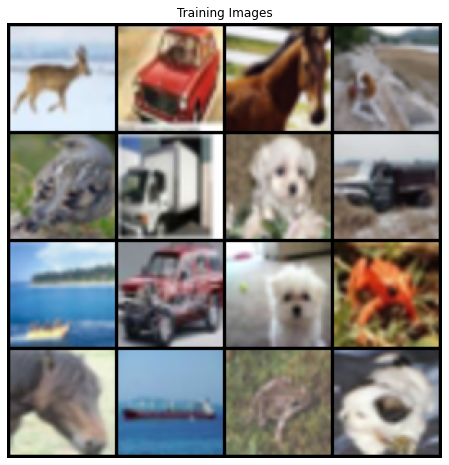

In [6]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:16],nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

plt.savefig('Results/WGANGP_Real.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


In [7]:
'''class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        # Defining the discriminator network layers
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # Define the first block
            self.Dnet(features_d, features_d * 2, 4, 2, 1),  
            # Define the second block
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  
            # Define the third block
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  
            # Final Convolutional layer to get the output
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    # Defining a block for discriminator
    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)
'''
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self.Dnet(features_d, features_d * 2, 4, 2, 1),  
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


In [8]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        
        # Define the generator network layers
        self.net = nn.Sequential(
            self.Gnet(channels_noise, features_g*8, 4, 1, 0),  
            self.Gnet(features_g*8, features_g*4, 4, 2, 1),   
            self.Gnet(features_g*4, features_g*2, 4, 2, 1),   
            self.Gnet(features_g*2, features_g, 4, 2, 1),      
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Final activation function to squash the output to [-1, 1]
        )

    # Defining a block for generator
    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),  # Batch normalization
            nn.ReLU(),  # ReLU activation
        )

    def forward(self, x):
        return self.net(x)


In [9]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [10]:
def GP(critic, real, fake):
    # Get the shape of the real images
    BATCH_SIZE, C, H, W = real.shape
    
    # Generate random alpha values for interpolation
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    
    # Create interpolated images using the alpha values
    interpolated_images = real * alpha + fake * (1 - alpha)
    
    # Pass interpolated images through the critic
    mixed_scores = critic(interpolated_images)
    
    # Compute gradients of mixed scores with respect to interpolated images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    # Flatten the gradients and compute their norm
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    
    # Compute the gradient penalty
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return gradient_penalty


In [11]:
def save_model(model):
    if model == 'gen':
        print("=> Saving model Generator!!")
        torch.save(model, "Models/CIFAR_wganGP_GENERATOR.pth.tar")
    elif model == 'disc':
        print("=> Saving model Discriminator!!")
        torch.save(model, "Models/CIFAR_wganGP_DIS.pth.tar")
        
def load_model(gen,disc):
    print("=> Loading Models!!")
    gen = torch.load("Models/CIFAR_wganGP_GENERATOR.pth.tar")
    disc = torch.load("Models/CIFAR_wganGP_DIS.pth.tar")

In [12]:
# Initialize the Generator and Discriminator models
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# Initialize the weights of the Generator and Discriminator
initialize_weights(gen)
initialize_weights(disc)

# Define the optimizers for both Generator and Discriminator
optimGenerator = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
optimDiscriminator = optim.RMSprop(disc.parameters(), lr=LEARNING_RATE)

# Create fixed noise for evaluation during training
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)

# Initialize step counter for tracking iterations
step = 0


In [13]:
gen.train() , disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTr

In [14]:
# Define the InceptionV3 model to extract features
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        # Initialize attributes
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        # Ensure the last_needed_block is within valid range
        assert self.last_needed_block <= 3, 'Last possible output block index is 3'

        # Initialize blocks from InceptionV3
        self.blocks = nn.ModuleList()
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        # Set requires_grad for model parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        # Resize input if required
        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        # Normalize input if required
        if self.normalize_input:
            x = 2 * x - 1

        # Pass input through the blocks
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)
            if idx == self.last_needed_block:
                break

        return outp

# Initialize the InceptionV3 model
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model = model.cuda()

# Function to calculate activation statistics
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    act = np.empty((len(images), dims))
    
    # Move images to GPU if CUDA is enabled
    if cuda:
        batch = images.cuda()
    else:
        batch = images
    
    # Get predictions from the model
    pred = model(batch)[0]
    
    # Ensure predictions are of the right size
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))
    
    # Convert predictions to numpy and reshape
    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    # Calculate mean and covariance
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    
    return mu, sigma



In [15]:
# Function to calculate Frechet distance
from scipy import linalg

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    # Handle numerical issues
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # Handle imaginary components
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

# Function to calculate FID score
def calculate_fretchet(images_real, images_fake, model):
    mu_1, std_1 = calculate_activation_statistics(images_real, model, cuda=True)
    mu_2, std_2 = calculate_activation_statistics(images_fake, model, cuda=True)
    
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [ ]:
# Initialize lists to store losses and images
GenLoss = []
DiscLoss = []
DiscLossP = []
img_list = []
iters = 0
FID_list = []

print("!!Training Started!!")

# Start timing
time_start = time.time()

# Loop over epochs
for epoch in range(NUM_EPOCHS):
    epoch = epoch + 1

    # Loop over batches in the dataloader
    for batch_idx, data in enumerate(dataloader, 0):
        # Extract real images from the data
        real = data[0].to(device)
        batch = real.shape[0]

        # Train the critic (discriminator)
        for i in range(criticItr):
            # Generate fake images
            noise = torch.randn(batch, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise)
            
            # Compute critic scores for real and fake images
            critic_real = disc(real).reshape(-1)
            critic_fake = disc(fake).reshape(-1)
            
            # Compute gradient penalty
            gp = GP(disc, real, fake)
            
            # Compute critic loss
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + (lambda_GP * gp))
            
            # Backpropagate and update critic weights
            disc.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimDiscriminator.step()

        # Train the generator
        output = disc(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        
        # Backpropagate and update generator weights
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        # Store losses
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())

        # Save generated images at certain intervals
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        # Calculate FID score
        fretchet_dist = calculate_fretchet(real, fake, model)
        FID_list.append(fretchet_dist)

        # Print current loss and FID score
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} "
              f"Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ", 
              end="\r", flush=True)

    # Generate and save images for each epoch
    labels = torch.arange(0, 10, dtype=torch.long, device=device)
    noise = torch.randn(10, 100, device=device)
    images = gen(fixed_noise)
    
    # Create directories to save images if they don't exist
    if not os.path.exists('Results/WGANGP_FAKE'):
        os.makedirs('Results/WGANGP_FAKE')
    if not os.path.exists('Results/WGANGP_REAL'):
        os.makedirs('Results/WGANGP_REAL')
    
    # Save generated and real images
    utils.save_image(images.detach(), 'Results/WGANGP_FAKE/WGANGP_epoch_%03d.png' % (epoch), normalize=True)
    utils.save_image(real.detach(), 'Results/WGANGP_REAL/WGANGP_epoch_%03d.png' % (epoch), normalize=True)

# End timing and print elapsed time
time_end = time.time()
print('\n\n elapsed time：%.2f s.' % (time_end - time_start))


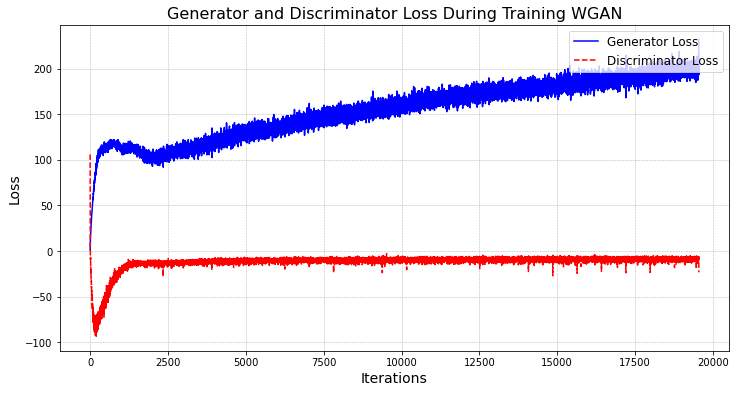

In [28]:
if not os.path.exists('Results/Loss_Data'):
       os.makedirs('Results/Loss_Data')
        
np.save('Results/Loss_Data/WGANGP_GLoss', GenLoss) 
np.save('Results/Loss_Data/WGANGP_DLoss', DiscLoss) 
GenLoss = np.load('Results/Loss_Data/WGANGP_GLoss.npy')
DiscLoss = np.load('Results/Loss_Data/WGANGP_DLoss.npy')
        
plt.figure(figsize=(12, 6))

# Generator Loss
plt.plot(GenLoss, label="Generator Loss", color='blue', linestyle='-', linewidth=1.5)

# Discriminator Loss
plt.plot(DiscLoss, label="Discriminator Loss", color='red', linestyle='--', linewidth=1.5)

# Title and labels
plt.title("Generator and Discriminator Loss During Training WGAN", fontsize=16)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Grid and legend
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend(loc="upper right", fontsize=12)

# Save and show plot
plt.savefig('Results/WGAN_LOSS.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


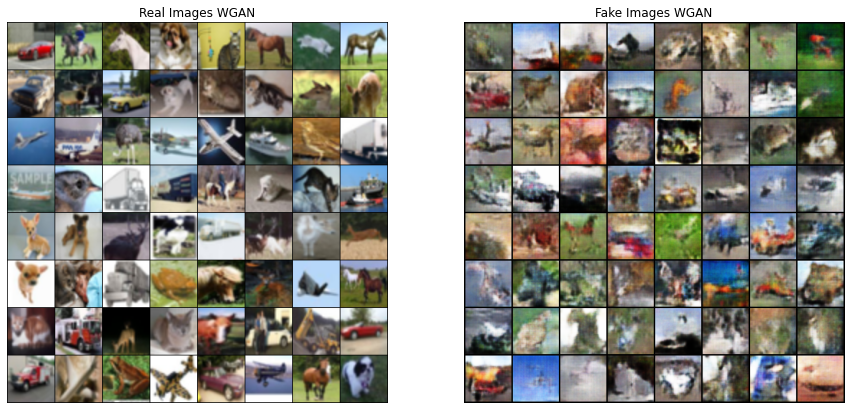

In [29]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images WGAN")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images WGAN")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('Results/WGAN_BEST.pdf',
            format='pdf',
            dpi=100,
            bbox_inches='tight')
plt.show()

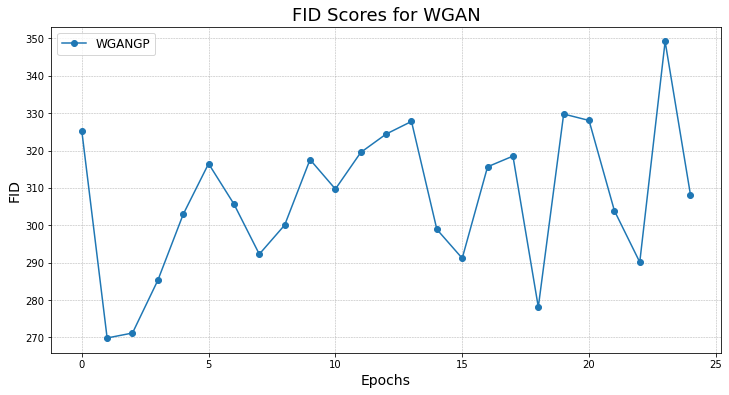

In [30]:
plt.figure(figsize=(12, 6))

# Plot FID scores with marker
plt.plot(FID_list, label="WGANGP", marker='o', linestyle='-')

# Title and labels
plt.title("FID Scores for WGAN", fontsize=18)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("FID", fontsize=14)

# Legend
plt.legend(fontsize=12)

# Grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save and show the plot
plt.savefig('Results/FID.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [24]:
if not os.path.exists('Results/FID_score'):
       os.makedirs('Results/FID_score')
np.save('Results/FID_score/WGANGP_FID', FID_list) 

In [20]:
np.min(FID_list), np.max(FID_list), np.mean(FID_list), FID_list[-5]

(342.5261025858814, 379.07836946694164, 364.33550543676887, 360.05769809653737)

In [21]:
np.mean(GenLoss),np.mean(DiscLoss),np.min(GenLoss),np.min(DiscLoss),GenLoss[-1],DiscLoss[-1]

(285.97482,
 -608.7612,
 282.6306,
 -615.94904,
 tensor(289.3141),
 tensor(-615.9490))